# Grouping Bounding Boxes

In [14]:
import numpy as np
import json
from PIL import Image, ImageDraw
from ast import literal_eval as make_tuple

In [9]:
with open('../tmp/prediction_cache.json') as fp:
    predictions = json.load(fp)

In [10]:
predictions.pop('ship_count')
predictions.pop('total_count')
predictions

{'(320, 310, 400, 390)': {'class': 'ship',
  'probabilities': [0.04011020064353943, 0.959889829158783],
  'classid': 1},
 '(330, 310, 410, 390)': {'class': 'ship',
  'probabilities': [0.040820375084877014, 0.9591796398162842],
  'classid': 1},
 '(330, 320, 410, 400)': {'class': 'ship',
  'probabilities': [0.004646673332899809, 0.9953533411026001],
  'classid': 1},
 '(330, 330, 410, 410)': {'class': 'ship',
  'probabilities': [0.02728489227592945, 0.9727151393890381],
  'classid': 1},
 '(340, 330, 420, 410)': {'class': 'ship',
  'probabilities': [0.06698773801326752, 0.9330123066902161],
  'classid': 1},
 '(330, 340, 410, 420)': {'class': 'ship',
  'probabilities': [0.05221474543213844, 0.9477851986885071],
  'classid': 1},
 '(340, 340, 420, 420)': {'class': 'ship',
  'probabilities': [0.010014559142291546, 0.989985466003418],
  'classid': 1},
 '(340, 350, 420, 430)': {'class': 'ship',
  'probabilities': [0.0007761828019283712, 0.9992238283157349],
  'classid': 1},
 '(350, 350, 430, 430

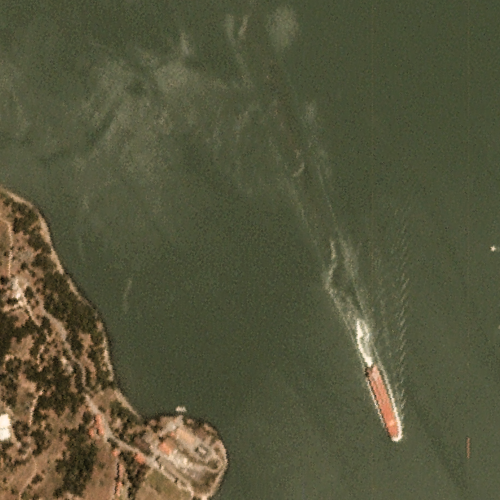

In [6]:
image = Image.open('../tmp/imgs/PSScene3Band_20180601_182249_103e_visual.tiff')
image = image.crop((1400, 1300, 1900, 1800))
image

How can we group points so that if they likely represent the same ship, we can average them together and draw the best box?
* Take euclidean distance between all points and create a new point list by averaging them together
* Find all boxes that overlap and average them together

In [46]:
points = np.array([make_tuple(point) for point in predictions.keys()])
# points.sort()
points

array([[320, 310, 400, 390],
       [330, 310, 410, 390],
       [330, 320, 410, 400],
       [330, 330, 410, 410],
       [340, 330, 420, 410],
       [330, 340, 410, 420],
       [340, 340, 420, 420],
       [340, 350, 420, 430],
       [350, 350, 430, 430],
       [340, 360, 420, 440],
       [350, 360, 430, 440],
       [340, 370, 420, 450],
       [350, 370, 430, 450],
       [350, 380, 430, 460],
       [350, 390, 430, 470]])

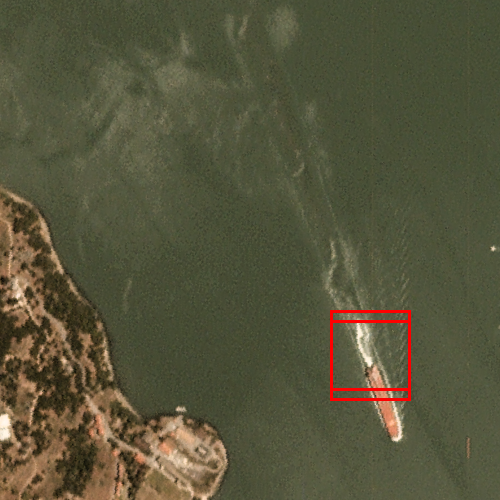

In [121]:
toy = image.copy()

draw = ImageDraw.Draw(toy)
for box in points[[1, 2]]:
    draw.rectangle(tuple(box), outline='red', width=3)
    
toy

## Euclidean Distances

In [48]:
def pairwise_euclidean_dist(coords):
    return np.sqrt(((coords[:, :, None] - coords[:, :, None].T) ** 2).sum(1))

In [59]:
# Hold this, mind needs something simpler rn
dist_mat = pairwise_euclidean_dist(points)
dist_mat[dist_mat > 0].min(), dist_mat.max()

(14.142135623730951, 120.83045973594572)

In [65]:
MAX_DIST = 100
dist_mat[1]

array([ 14.14213562,   0.        ,  14.14213562,  28.28427125,
        31.6227766 ,  42.42640687,  44.72135955,  58.30951895,
        63.2455532 ,  72.11102551,  76.15773106,  86.02325267,
        89.4427191 , 102.95630141, 116.6190379 ])

In [ ]:
dist_mat[dist_mat < MAX_DIST]

## Overlapping Rectangles

In [131]:
# Intersects, return True if one rectangles corner contained in another
# def intersects(self, other):
#     return not (self.top_right.x < other.bottom_left.x or self.bottom_left.x > other.top_right.x or self.top_right.y < other.bottom_left.y or self.bottom_left.y > other.top_right.y)

# left, top, right, bottom
point1 = points[1]
point2 = points[-1]

def boxes_overlap(point1, point2):
    return ((point2[0] > point1[0] and point2[0] < point1[2]) or (point2[2] > point1[0] and point2[2] < point1[2]) # x overlap
            or any(point1[[0, 2]] == point2[[0,2]]) or any(point1[[1, 3]] == point2[[1, 3]])  # shares axes
            and (point2[1] > point1[1] and point2[1] < point1[3]) or (point2[3] > point1[1] and point2[3] < point1[3])) # y overlap

In [164]:
extra_points = np.concatenate((points, points + 150))

def np_pop(arr):
    x = arr[0]
    np.delete(arr, 0)
    return x

np_pop(extra_points)

array([320, 310, 400, 390])

In [167]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
#  
   # initialize the list of picked indexes   
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

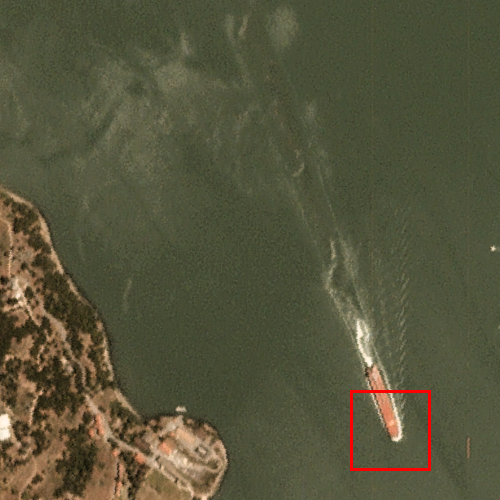

In [169]:
toy = image.copy()
draw = ImageDraw.Draw(toy)

for point in non_max_suppression_fast(extra_points, 0):
    draw.rectangle(tuple(point), outline='red', width=3)
    
toy